<a href="https://colab.research.google.com/github/ghoshmithun/Sem3_DL_Assignment2020/blob/main/Movie_Sentiment_Classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-10-19 15:46:44--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.7MB/s    in 5.3s    

2020-10-19 15:46:49 (15.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -xzf aclImdb_v1.tar.gz 

In [ ]:
ls -a

./  ../  aclImdb/  aclImdb_v1.tar.gz  .config/  sample_data/


We have the data downloaded in the aclImdb folder. Lets explore the data

We are printing the readme which has the description fo the **data**

In [ ]:
!ls -a aclImdb/

.  ..  imdbEr.txt  imdb.vocab  README  test  train


In [ ]:
!cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [ ]:
!head -10 aclImdb/train/pos/4298_10.txt

This movie awed me so much that I watch it at least once a year. At times I find it uncomfortable. At times I find it empowering. And I always find the characters human and real. It is a movie that shows you the gritty reality of life in LA, starting with the recurring helicopter search lights scanning for the dangers lurking so close to the ordinary lives being carried on by the characters. It is also a movie that shows you how the kindness of a stranger can change your life and empower you to make a difference. Grand Canyon reminds you that every action you take, whether intended or not, has powerful repercussions. I found this movie to be similar in many ways to Robert Altman's film Short Cuts. Both had a star-studded roster of perfectly cast actors & actresses and both movies allowed you to gradually see how the the characters interrelated with one another and affected each other, for better or worse. Grand Canyon did a better job of providing a cohesive message, (hope in the face 

Each of the reviews are kept as a file , so we have to merge them

In [ ]:
import glob
import os
def create_file(file_dir,final_file_name,label):
  os.chdir(file_dir)
  read_files = glob.glob("*.txt")
  with open(final_file_name, "w") as outfile:
      for f in read_files:
          with open(f, "r") as infile:
              outfile.write(str(infile.read()) + '||' + label + '\n')

In [ ]:
os.getcwd()

'/content'

In [ ]:
create_file('/content/aclImdb/train/pos','all_pos_comments.txt','1')

In [ ]:
create_file('/content/aclImdb/train/neg','all_neg_comments.txt','0')

Finally we have processed the data and uploaded here in csv format for easy experimentation. 

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
ls

gdrive/  sample_data/


In [10]:
ls -al /content/gdrive/My\ Drive/Sem3/DL/project/

total 64665
-rw------- 1 root root 66212309 Oct 19  2019 'IMDB Dataset.csv'
drwx------ 2 root root     4096 Oct 19 14:53  model_artifacts/


In [11]:
import pandas as pd

imdb_data = pd.read_csv('/content/gdrive/My Drive/Sem3/DL/project/IMDB Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Review column has html tags . We have to get rid of those



In [12]:
import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [13]:
imdb_data['clean_review'] = imdb_data['review'].apply(cleanhtml)
imdb_data['label'] = imdb_data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

imdb_data.head()

,review,sentiment,clean_review,label
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imdb_data['clean_review'].values, imdb_data['label'].values, test_size=0.2)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.5)

print("Shape of train data:", len(X_train))
print("Shape of CV data:", len(X_cv))
print("Shape of test data:", len(X_test))

Shape of train data: 20000
Shape of CV data: 20000
Shape of test data: 10000


In [18]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras.layers import Dense , Input, Dropout, Activation
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder

MAX_LEN=500
MAX_WORDS=5000
EPOCH=10
TOKENIZER='/content/gdrive/My Drive/Sem3/DL/project/model_artifacts/bi_lstm_tokenizer.pickle'
MODEL_PATH = '/content/gdrive/My Drive/Sem3/DL/project/model_artifacts/lstm_bidir.model'

le = LabelEncoder()

def get_bi_lstm_model(mode='sum',max_len=MAX_LEN,max_words=MAX_WORDS):
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,128,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(128, return_sequences=False), input_shape=(128, 1), merge_mode=mode)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

# Only call the below function, It will define the model as above
def model_compile():
    model = get_bi_lstm_model()
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

def train_model(model,X,y,X_cv,y_cv, epoch =EPOCH, model_path=None):
    hist = model.fit(X, y, epochs=epoch, batch_size=16, verbose=1,validation_data=(X_cv, y_cv),
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
    
    if model_path:
        path = model_path
    else:
        path =  MODEL_PATH
    save_model(
        model, filepath=path , overwrite=True, include_optimizer=True, save_format=None,
        signatures=None, options=None
    )
    return model,hist

def convert_y(y):
  return le.fit_transform(y)

In [16]:
import os

def save_pickle(path,object):
    with open(path, 'wb') as handle:
        pickle.dump(object, handle)

def read_pickle(path):
    with open(path, 'rb') as handle:
        object = pickle.load(handle)
    return object


def data_processing_model(X,train=False):
    """
    :param X: sentences in list format
    :param train: if train time then save
    :return: tokenized matrix for DL input
    """
    path = os.path.join(TOKENIZER)
    texts = [line.lower().split(" ") for line in X]
    if not train:
        tok = read_pickle(path)
    else:
      tok = Tokenizer(num_words=MAX_WORDS)
      tok.fit_on_texts(texts)
    text_tokenized = tok.texts_to_sequences(texts)
    if train:
        save_pickle(path, tok)
    text_sequence = sequence.pad_sequences(text_tokenized, maxlen=MAX_LEN)
    return text_sequence

In [17]:
X_train2=data_processing_model(X_train,train=True)
X_cv2 = data_processing_model(X_cv,train=False)

In [19]:
model=model_compile()
model, history=train_model(model,X=X_train2,y=y_train,X_cv=X_cv2,y_cv=y_cv)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               263168    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

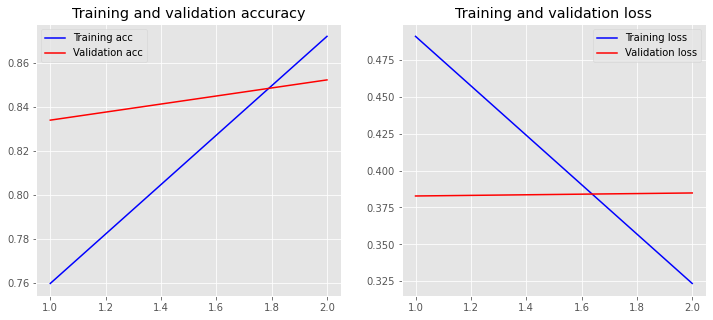

In [20]:
from matplotlib import pyplot
def plot_history(history):
    pyplot.style.use('ggplot')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    pyplot.figure(figsize=(12, 5))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(x, acc, 'b', label='Training acc')
    pyplot.plot(x, val_acc, 'r', label='Validation acc')
    pyplot.title('Training and validation accuracy')
    pyplot.legend()
    pyplot.subplot(1, 2, 2)
    pyplot.plot(x, loss, 'b', label='Training loss')
    pyplot.plot(x, val_loss, 'r', label='Validation loss')
    pyplot.title('Training and validation loss')
    pyplot.legend()

plot_history(history)

In [21]:
def score_data(txt,tok,max_len=MAX_LEN):
    path = MODEL_PATH
    txts = data_processing_model(txt,train=False)
    model = load_model(path)
    preds = model.predict(txts)
    return preds

In [22]:
# Some Random Example


sample_texts = ["what an awesome movie","if this is good then nothing is bad"]
print(score_data(sample_texts,tok=read_pickle(TOKENIZER)))

[[0.78572357]
 [0.0984959 ]]


In [23]:
y_pred_test = score_data(X_test,tok=read_pickle(TOKENIZER))

In [24]:
y_pred_test=y_pred_test.ravel()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=list(map(lambda x: int(x>0.5),y_pred_test)), y_true=y_test))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      4992
           1       0.80      0.92      0.85      5008

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



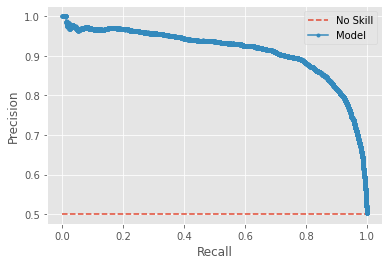

In [26]:
from sklearn.metrics import precision_recall_curve
def plot_pr_curve(test_y, model_probs):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Model')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()


plot_pr_curve(y_test,y_pred_test)

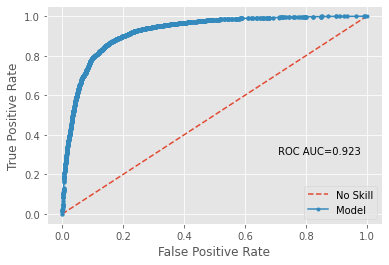

In [28]:
# plot no skill and model roc curves
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(test_y, model_probs,save=False):
    pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    pyplot.plot(fpr, tpr, marker='.', label='Model')
    auc = roc_auc_score(test_y, model_probs)
    pyplot.text(0.7,0.3,' ROC AUC=%.3f' % (auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    if save:
        return pyplot
    # show the plot
    pyplot.show()

plot_roc_curve(y_test,y_pred_test)